# Feature Engineering Notebook

## Objectives

*   Engineer features for Classification, Regression and Cluster models


## Inputs

* inputs/datasets/cleaned/TrainSet.csv
* inputs/datasets/cleaned/TestSet.csv

## Outputs

* generate a list with variables to engineer

## Additional Comments | Insights | Conclusions



* Feature Engineering Transformers
  * Ordinal categorical encoding: `['gender', 'Partner', Dependents', 'PhoneService','MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','Contract', 'PaperlessBilling', 'PaymentMethod']`
  * Smart Correlation Selection: `['OnlineSecurity', 'DeviceProtection', 'TechSupport']`
  


---

# Install Packages

In [ ]:
! pip install pandas-profiling==2.11.0
! pip install feature-engine==1.0.2
! pip install ppscore==1.2.0

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

We want to make the parent of current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

---

# Load Cleaned Data

Train Set

In [ ]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.info()

Test Set

In [ ]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.info()

# Pandas Profiling

Quick exploration 

In [ ]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

# Correlation and PPS Analysis

Supporting functions

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

def heatmap_corr(df,threshold):
  if len(df.columns) > 1:
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    fig, axes = plt.subplots(figsize=(20,12))
    sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                     mask=mask, cmap='viridis', annot_kws={"size": 8}, ax=axes
                     )
    axes.set_yticklabels(df.columns, rotation = 0)
    plt.ylim(len(df.columns),0)
    plt.show()


def heatmap_pps(df,threshold):
    if len(df.columns) > 1:

      mask = np.zeros_like(df, dtype=np.bool)
      mask[abs(df) < threshold] = True

      fig, ax = plt.subplots(figsize=(20,12))
      ax = sns.heatmap(df, annot=True, xticklabels=True,yticklabels=True,
                        mask=mask,cmap='rocket_r', annot_kws={"size": 8})
      
      plt.ylim(len(df.columns),0)
      plt.show()



def CalculateCorrAndPPS(df):
  df_corr_spearman = df.corr(method="spearman")
  df_corr_pearson = df.corr(method="pearson")

  pps_matrix_raw = pps.matrix(df)
  pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

  pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
  print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
  print(pps_score_stats.round(3))

  return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix,CorrThreshold,PPS_Threshold):

  print("\n")
  print("* Analyze how the target variable for your ML models are correlated with other variables (features and target)")
  print("* Analyze multi colinearity, that is, how the features are correlated among themselves")

  print("\n")
  print("*** Heatmap: Spearman Correlation ***")
  print("It evaluates monotonic relationship \n")
  heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold)

  print("\n")
  print("*** Heatmap: Pearson Correlation ***")
  print("It evaluates the linear relationship between two continuous variables \n")
  heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold)

  print("\n")
  print("*** Heatmap: Power Predictive Score (PPS) ***")
  print(f"PPS detects linear or non-linear relationships between two columns.\n"
        f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
  heatmap_pps(df=pps_matrix,threshold=PPS_Threshold)

Calculate Correlations and Power Predictive Score

In [9]:
dataset = pd.concat([TrainSet, TestSet], axis=0)
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(dataset)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%    50%    75%    max
ppscore  341.0  0.124  0.181  0.0  0.0  0.012  0.182  0.786


Display at Heatmaps



* Analyze how the target variable for your ML models are correlated with other variables (features and target)
* Analyze multi colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



/home/vscode/.local/lib/python3.8/site-packages/seaborn/matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/vscode/.local/lib/python3.8/site-packages/seaborn/matrix.py:209: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


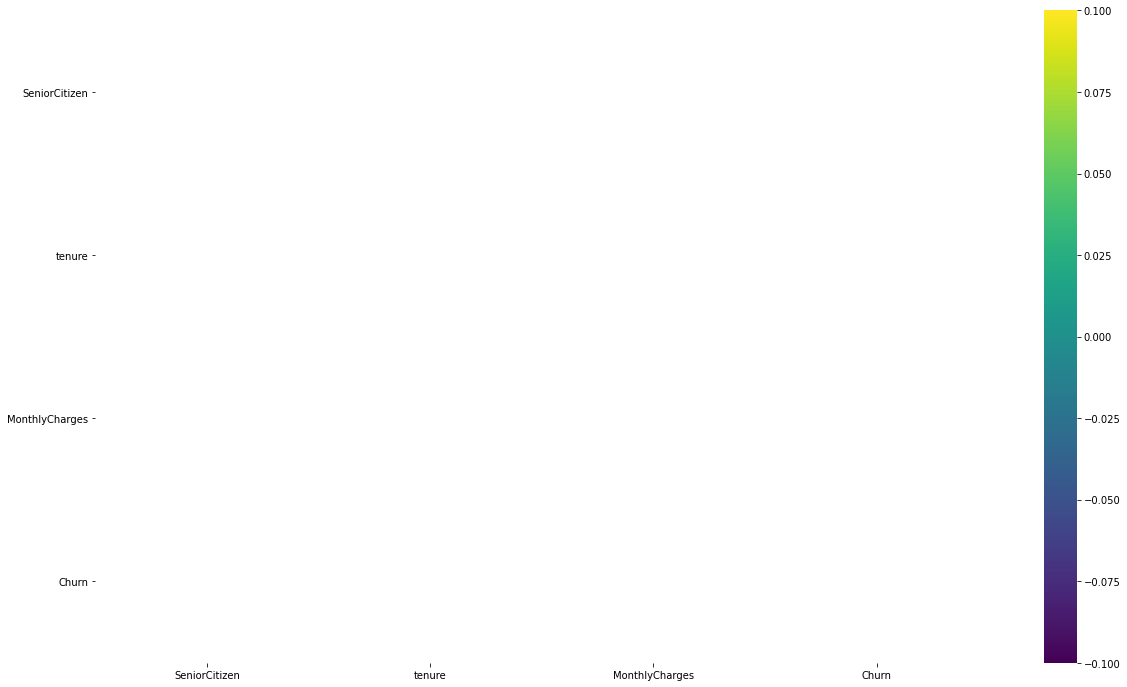



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



/home/vscode/.local/lib/python3.8/site-packages/seaborn/matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/vscode/.local/lib/python3.8/site-packages/seaborn/matrix.py:209: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


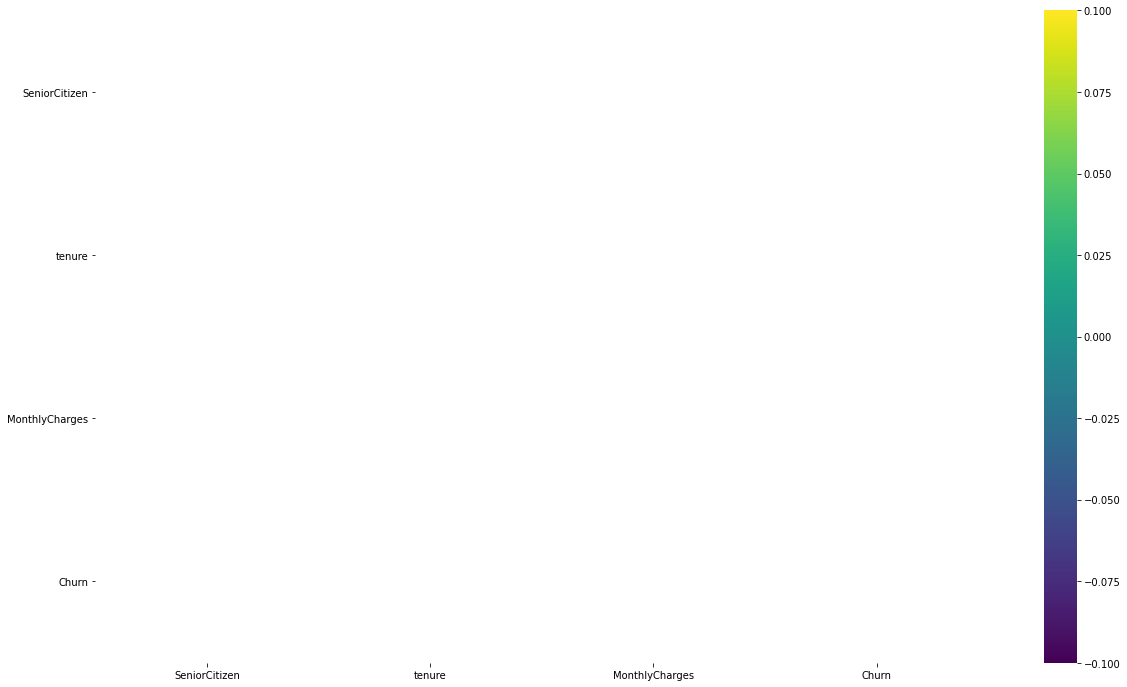



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



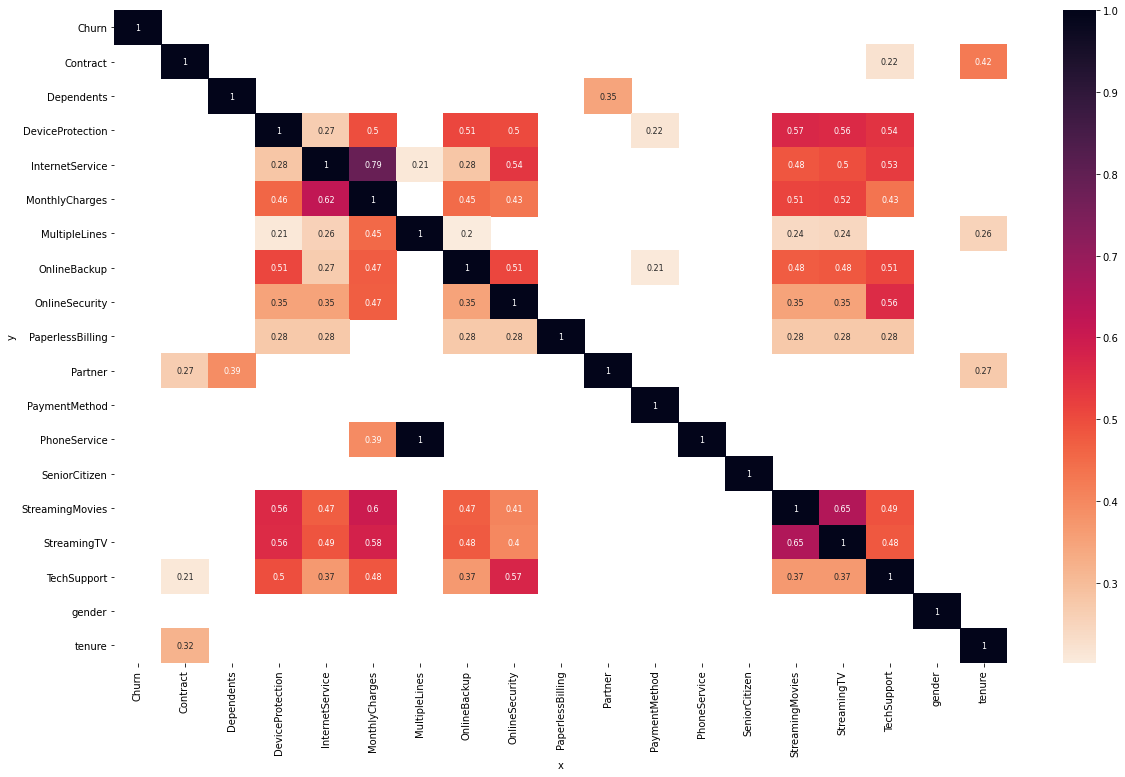

In [11]:
DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix,
                  CorrThreshold=0.4, PPS_Threshold=0.2)

# Feature Engineering

## Custom function

Custom functions for engineering variables

In [12]:
from feature_engine import transformation as vt
from feature_engine.discretisation import EqualFrequencyDiscretiser, EqualWidthDiscretiser
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import RareLabelEncoder
from feature_engine.encoding import OrdinalEncoder



import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings('ignore')


def FeatureEngineering(df,analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape 
    - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions

    """


    ### Check analyis type
    allowed_types= f"'numerical', 'outlier', 'discretization', 'ordinal_encoder' or 'outlier_winsorizer'. "
    if analysis_type == None:
      raise SystemExit(f"You should pass analysis_type parameter as one of the following options: {allowed_types} ")
    if analysis_type not in allowed_types:
      raise SystemExit(f"analysis_type argument should be either {allowed_types}")


    ### Set suffix colummns acording to analysis_type
    if analysis_type=='numerical':
      list_column_transformers = ["lte","lt10","rt", "pt","bct","yj"]
    
    elif analysis_type=='outlier':
      list_column_transformers = ["lt","rt", "pt","bct","yj"]
    
    elif analysis_type=='discretization':
      list_column_transformers = ['equal_frequency_5intervals',
                                  'equal_frequency_10intervals',
                                  'equal_width_5intervals',
                                  'equal_width_10intervals']
    
    elif analysis_type=='ordinal_encoder':
      list_column_transformers = ["ordinal_encoder"]

    elif analysis_type=='outlier_winsorizer':
      list_column_transformers = ['gaussian', 'iqr']



    # empty engineered dataframe
    df_feat_eng = pd.DataFrame([]) 
    
    for column in df.columns:

      ### create additional columns (column_method) to apply the methods
      df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
      for method in list_column_transformers:
        df_feat_eng[f"{column}_{method}"] = df[column]
        
      ### Apply transformers in respectives column_transformers
      if analysis_type=='numerical':
        df_feat_eng,list_applied_transformers = FeatEngineering_Numerical(df_feat_eng,column)
      
      elif analysis_type=='discretization':
        df_feat_eng,list_applied_transformers = FeatEngineering_Discretization(df_feat_eng,column)
      
      elif analysis_type=='outlier_winsorizer':
        df_feat_eng,list_applied_transformers = FeatEngineering_OutlierWinsorizer(df_feat_eng,column)

      elif analysis_type=='ordinal_encoder':
        df_feat_eng,list_applied_transformers = FeatEngineering_CategoricalEncoder(df_feat_eng,column)

      
      # For each variable, assess how the transformations perform
      print(f"* Variable Analyzed: {column}")
      print(f"* Applied transformation: {list_applied_transformers} \n")
      for col in [column] + list_applied_transformers:
        
        if analysis_type!='ordinal_encoder':
          DiagnosticPlots_Numerical(df_feat_eng, col)
        
        else:
          if col == column: 
            DiagnosticPlots_Categories(df_feat_eng, col)
          else:
            DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


    return df_feat_eng


def DiagnosticPlots_Categories(df_feat_eng, col):
  plt.figure(figsize=(20, 5))
  sns.countplot(data=df_feat_eng, x=col,palette=['#432371'],order = df_feat_eng[col].value_counts().index)
  plt.xticks(rotation=90) 
  plt.suptitle(f"{col}", fontsize=30,y=1.05)        
  plt.show();
  print("\n")



def DiagnosticPlots_Numerical(df, variable):

    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20, 6))

    sns.histplot(data=df, x=variable, kde=True,element="step",ax=ax1) 
    stats.probplot(df[variable], dist="norm", plot=ax2)
    sns.boxplot(x=df[variable],ax=ax3)
    
    # analysis on outliers
    # shapiro analysis
    ax1.set_title('Histogram')
    ax2.set_title('Probability Plot')
    ax3.set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30,y=1.05)
    plt.show();


def FeatEngineering_CategoricalEncoder(df_feat_eng,column):
  list_methods_worked = []
  try:
    encoder= OrdinalEncoder(encoding_method='arbitrary', variables = [f"{column}_ordinal_encoder"])
    df_feat_eng = encoder.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_ordinal_encoder")
  except: 
    df_feat_eng.drop([f"{column}_ordinal_encoder"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng,column):

  list_methods_worked = []

  ### Winsorizer gaussian
  try: 
    disc=Winsorizer(
        capping_method='gaussian', tail='both', fold=3,variables = [f"{column}_gaussian"])
    df_feat_eng = disc.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_gaussian")
  except: 
    df_feat_eng.drop([f"{column}_gaussian"],axis=1,inplace=True)

  ### Winsorizer iqr
  try: 
    disc=Winsorizer(
        capping_method='iqr', tail='both', fold=3,variables = [f"{column}_iqr"])
    df_feat_eng = disc.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_iqr")
  except: 
    df_feat_eng.drop([f"{column}_iqr"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked






def FeatEngineering_Discretization(df_feat_eng,column):

  list_methods_worked = []

  ### EqualFrequencyDiscretiser
  try: 
    disc= EqualFrequencyDiscretiser(q=5,variables = [f"{column}_equal_frequency_5intervals"])
    df_feat_eng = disc.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_equal_frequency_5intervals")
  except: 
    df_feat_eng.drop([f"{column}_equal_frequency_5intervals"],axis=1,inplace=True)


  ### EqualFrequencyDiscretiser
  try: 
    disc= EqualFrequencyDiscretiser(q=10,variables = [f"{column}_equal_frequency_10intervals"])
    df_feat_eng = disc.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_equal_frequency_10intervals")
  except: 
    df_feat_eng.drop([f"{column}_equal_frequency_10intervals"],axis=1,inplace=True)


  ### EqualWidthDiscretiser
  try: 
    disc= EqualWidthDiscretiser(bins=5,variables = [f"{column}_equal_width_5intervals"])
    df_feat_eng = disc.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_equal_width_5intervals")
  except: 
    df_feat_eng.drop([f"{column}_equal_width_5intervals"],axis=1,inplace=True)


  ### EqualWidthDiscretiser
  try: 
    disc= EqualWidthDiscretiser(bins=10,variables = [f"{column}_equal_width_10intervals"])
    df_feat_eng = disc.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_equal_width_10intervals")
  except: 
    df_feat_eng.drop([f"{column}_equal_width_10intervals"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked
  
  

def FeatEngineering_Numerical(df_feat_eng,column):

  list_methods_worked = []

  ### LogTransformer base e
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_lte"])
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_lte")
  except: 
    df_feat_eng.drop([f"{column}_lte"],axis=1,inplace=True)

    ### LogTransformer base 10
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_lt10"],base='10')
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_lt10")
  except: 
    df_feat_eng.drop([f"{column}_lt10"],axis=1,inplace=True)

  ### ReciprocalTransformer
  try:
    rt = vt.ReciprocalTransformer(variables = [f"{column}_rt"])
    df_feat_eng =  rt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_rt")
  except:
    df_feat_eng.drop([f"{column}_rt"],axis=1,inplace=True)

  ### PowerTransformer
  try:
    pt = vt.PowerTransformer(variables = [f"{column}_pt"])
    df_feat_eng = pt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_pt")
  except:
    df_feat_eng.drop([f"{column}_pt"],axis=1,inplace=True)

  ### BoxCoxTransformer
  try:
    bct = vt.BoxCoxTransformer(variables = [f"{column}_bct"])
    df_feat_eng = bct.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_bct")
  except:
    df_feat_eng.drop([f"{column}_bct"],axis=1,inplace=True)


  ### YeoJohnsonTransformer
  try:
    yjt = vt.YeoJohnsonTransformer(variables = [f"{column}_yj"])
    df_feat_eng = yjt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_yj")
  except:
        df_feat_eng.drop([f"{column}_yj"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked




## Feature Engineering Spreadsheet Summary

At this stage, there are no missing data in your Train and Test sets.


Now you are looking to engineer (**to transform**), your variables, so the Machine Learning model will better learn the relationships among the variables (features and labels).
  * It is important to run a quick EDA to asess variables distribution shape. Machine Learning models learn better when the distribution is normal. To engineer that, you can use transformers in packages like feature-engine or sklearn.
  * You can also use your business acumen and technical expertise to create new variables. For example, imagine if your dataset is about your orange juice company operation. There is a variable called "revenue" and other called "volume", you divide revenue by volume to know how much money you make per liter of manufactured juice

---   

**REMINDER**
  * The transformers decided in this notebook will serve as base to construct the **ML Pipeline** for the upcoming notebooks!

---

**Strategy**


* **1 - Do a quick EDA and evaluate distribution from all variables. List all variables and potential transformation to apply on each (including no transformation)**



* **2 - Consider the following template to help your engineering process**

  * 1 - Select variable(s)
  * 2 - Select the transformer(s)
  * 3 - Create a separate dataframe, for that variable(s)
  * 4 - Create engineered variables(s) applying the transformation(s)
  * 5 - Assess engineered variables distribution and select most suitable transformation
  * 6 - If you are satisfied, apply the selected transformation to the Train and Test set


## Dealing with Feature Engineering

### Categorical Enconding - Ordinal: replaces categories by ordinal numbers 

* Step 1: Select variable(s)

In [13]:
variables_engineering= ['gender', 'Partner', 'Dependents', 'PhoneService',
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                        'Contract', 'PaperlessBilling', 'PaymentMethod']

variables_engineering

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

* Step 2: Select the engineering transformation(s)

In [14]:
from feature_engine.encoding import OrdinalEncoder

* Step 3: Create a separate dataframe, with your variable(s)

In [15]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,Female,Yes,No,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check
1,Female,No,No,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,Female,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


* Step 4: Create engineered variables(s) applying the transformation(s), assess engineered variables distribution and select most suitable method for each variable

* Variable Analyzed: gender
* Applied transformation: ['gender_ordinal_encoder'] 



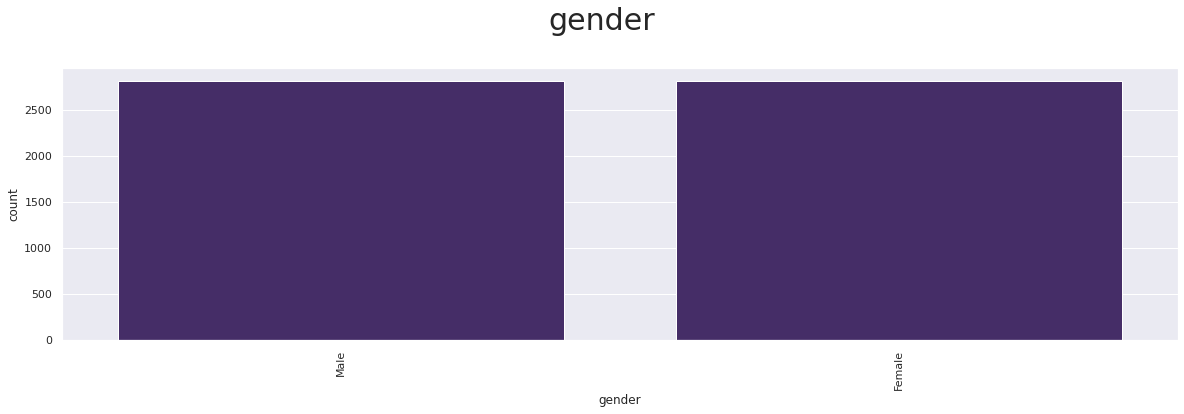

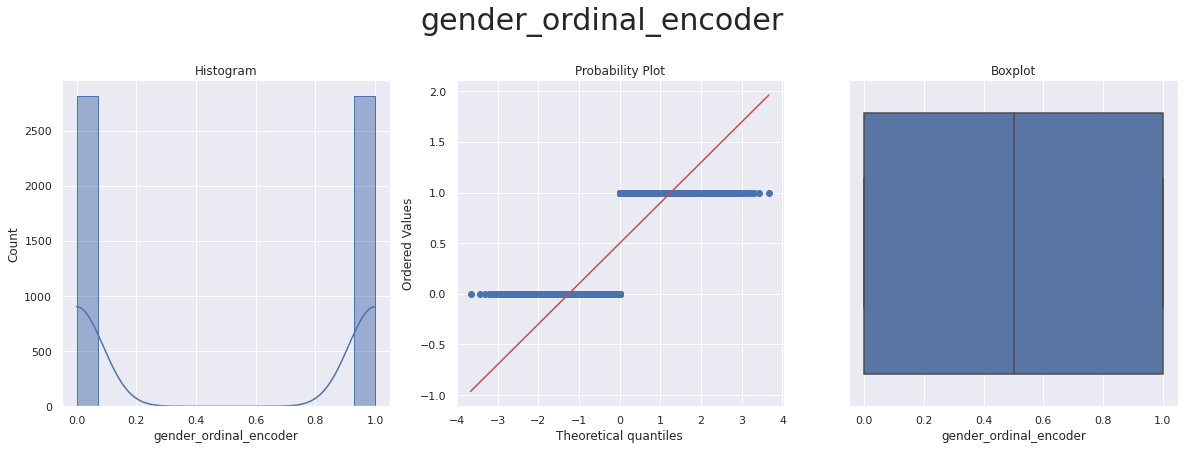



* Variable Analyzed: Partner
* Applied transformation: ['Partner_ordinal_encoder'] 



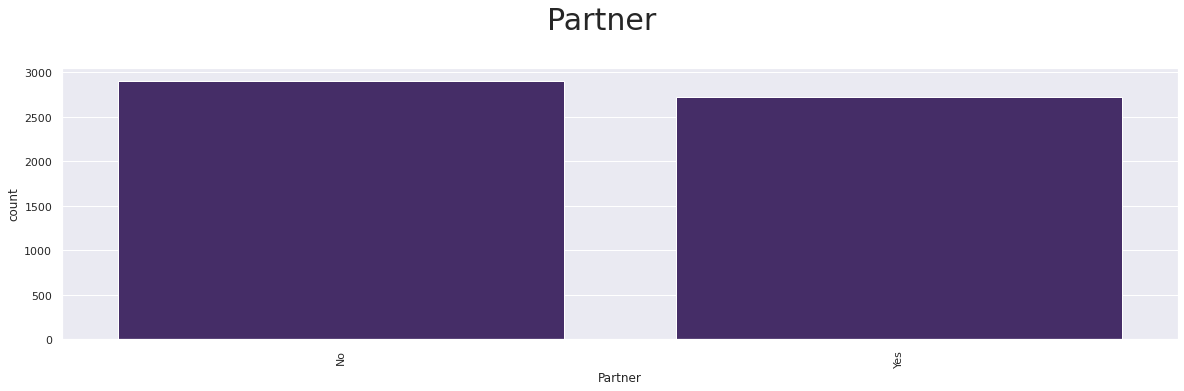

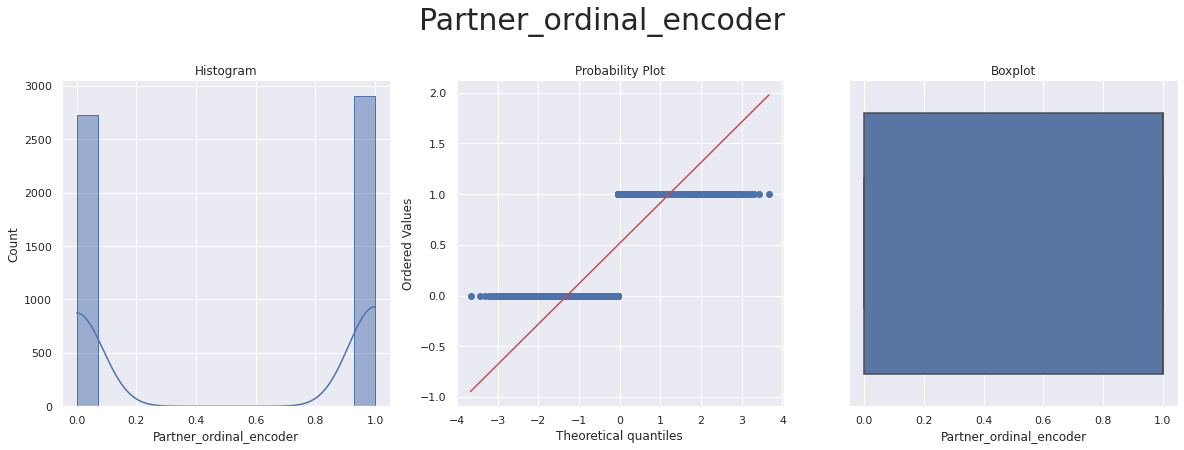



* Variable Analyzed: Dependents
* Applied transformation: ['Dependents_ordinal_encoder'] 



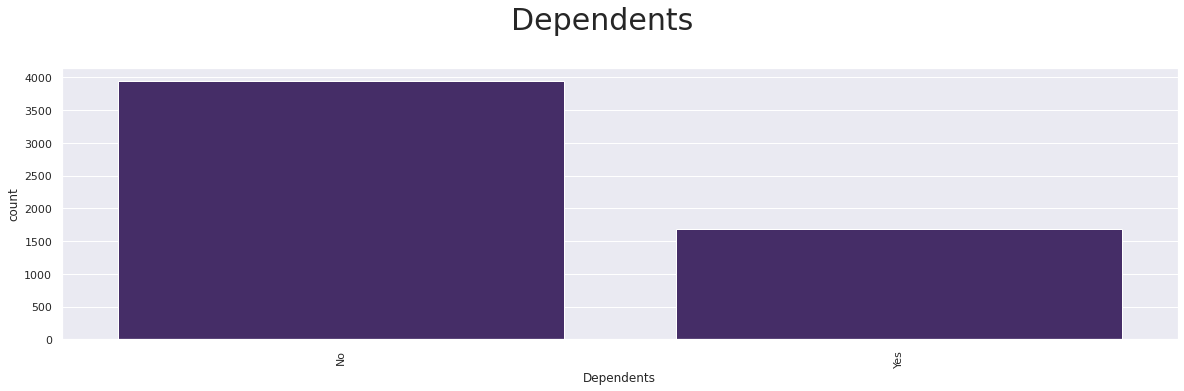

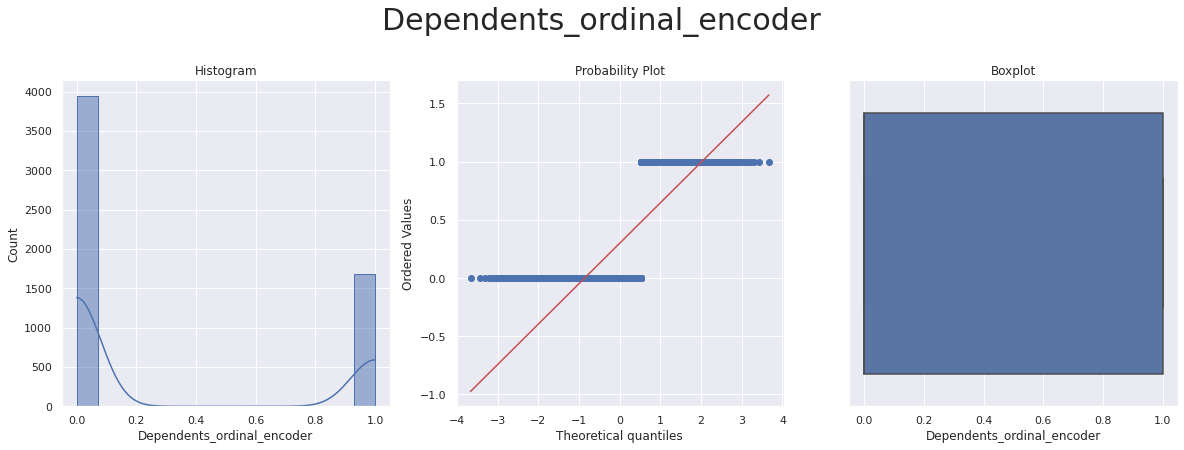



* Variable Analyzed: PhoneService
* Applied transformation: ['PhoneService_ordinal_encoder'] 



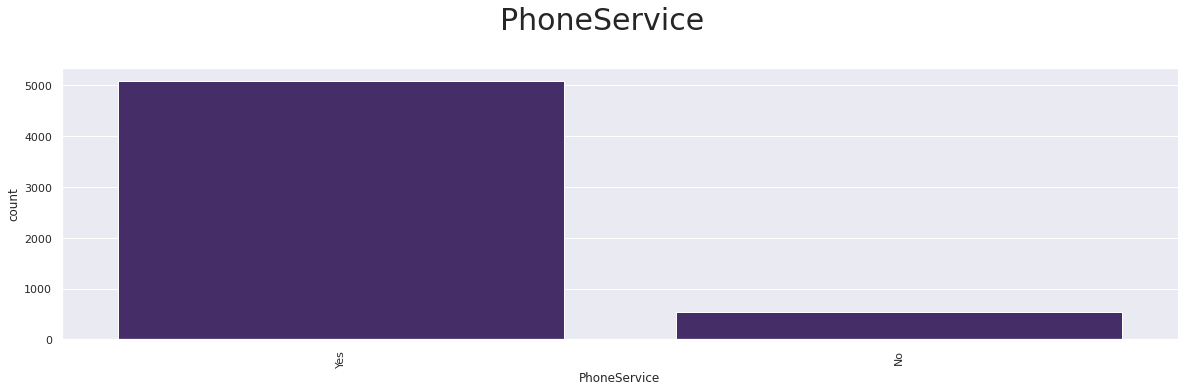

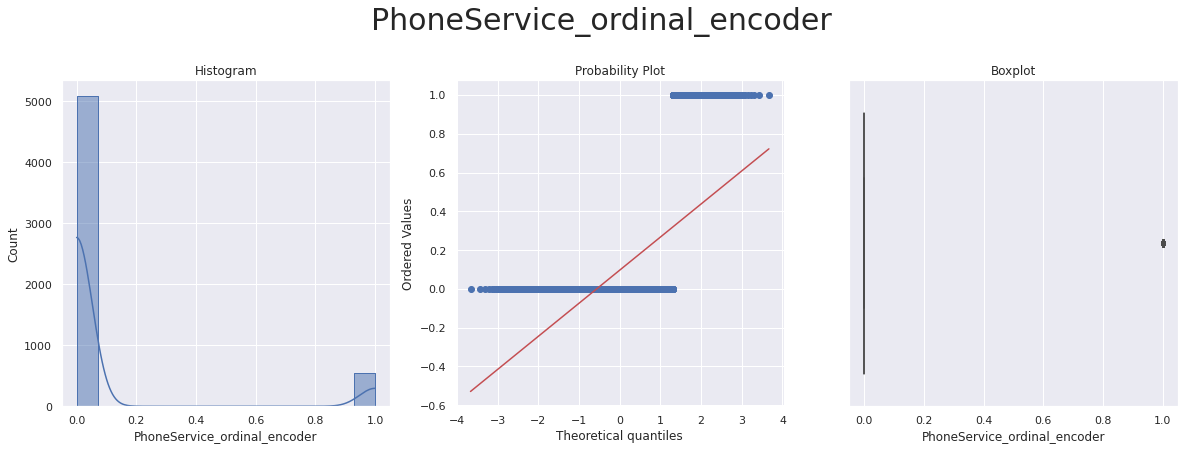



* Variable Analyzed: MultipleLines
* Applied transformation: ['MultipleLines_ordinal_encoder'] 



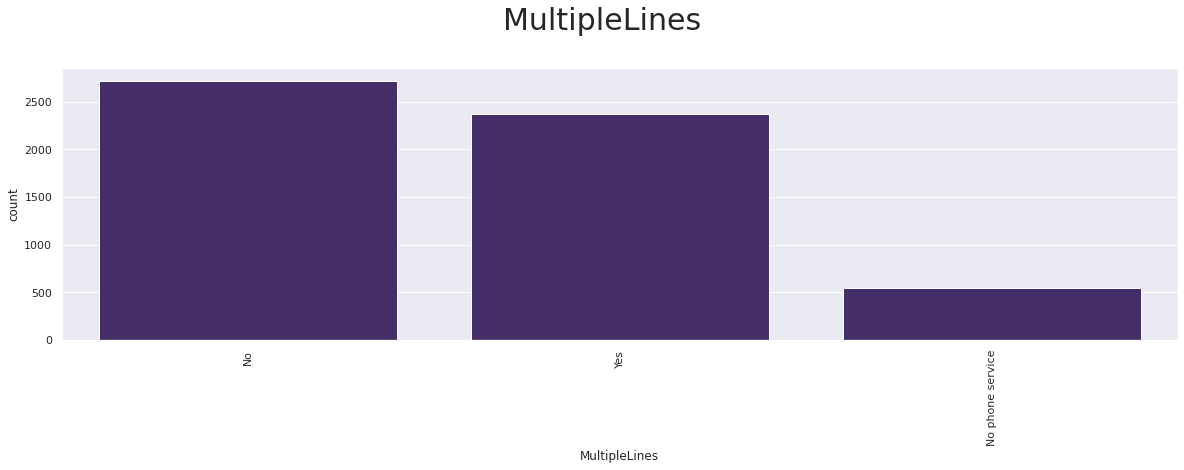

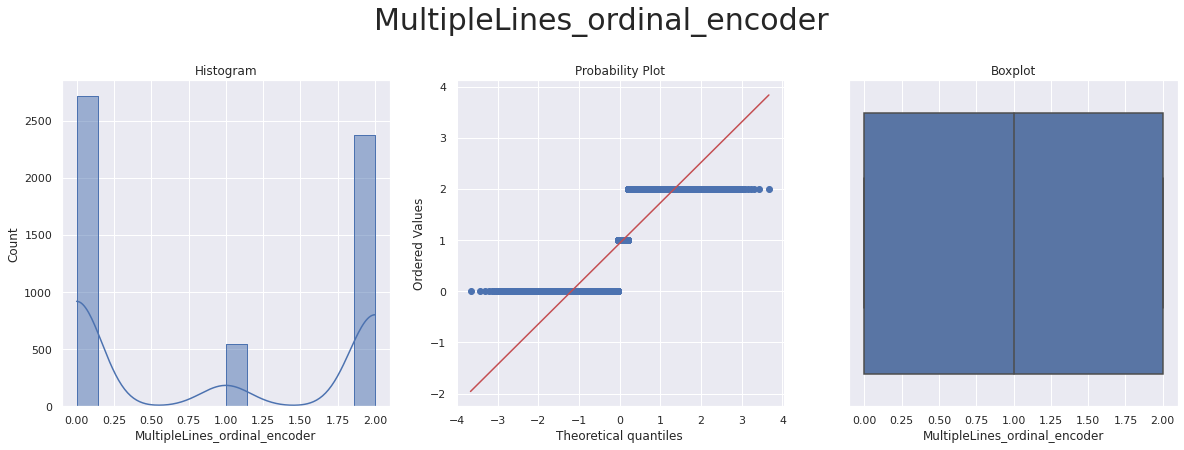



* Variable Analyzed: InternetService
* Applied transformation: ['InternetService_ordinal_encoder'] 



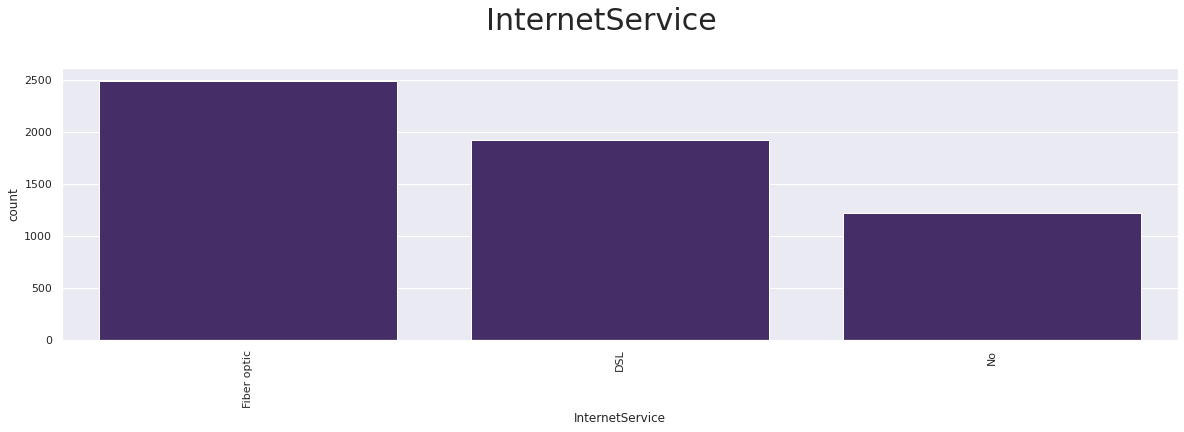

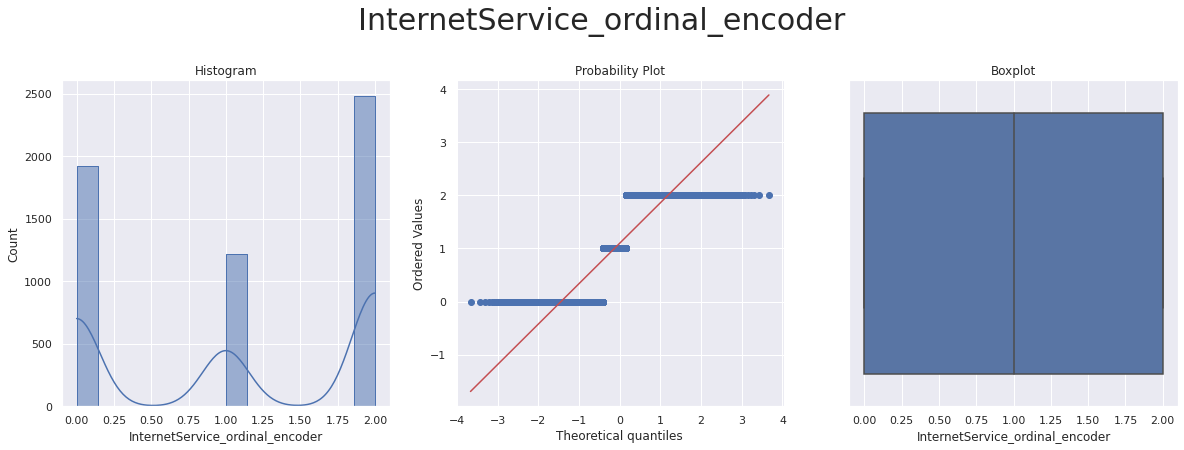



* Variable Analyzed: OnlineSecurity
* Applied transformation: ['OnlineSecurity_ordinal_encoder'] 



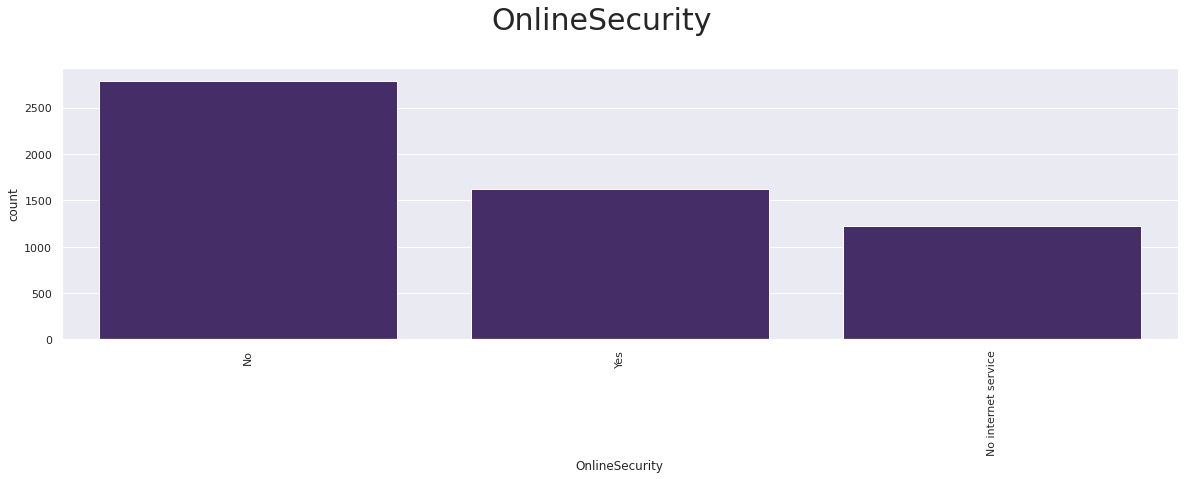

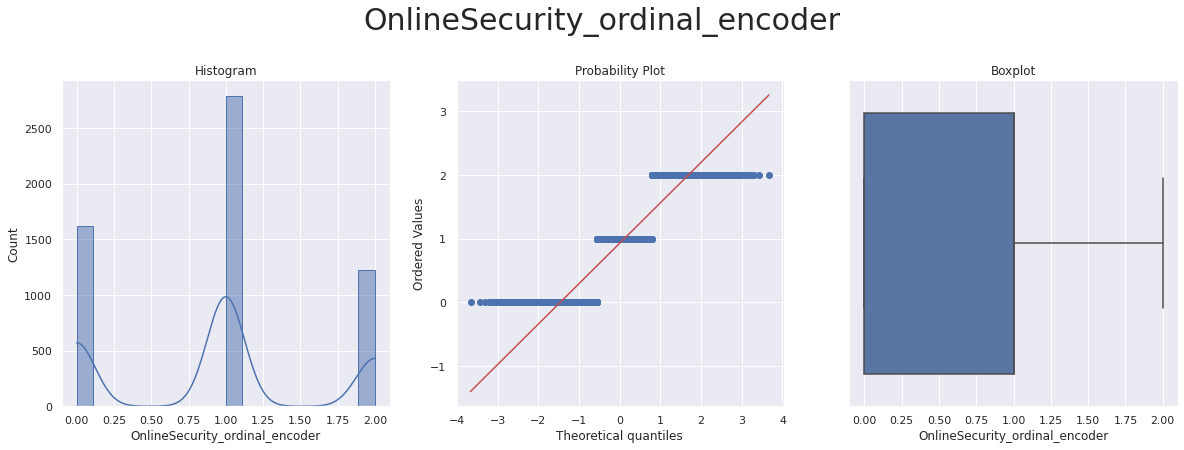



* Variable Analyzed: OnlineBackup
* Applied transformation: ['OnlineBackup_ordinal_encoder'] 



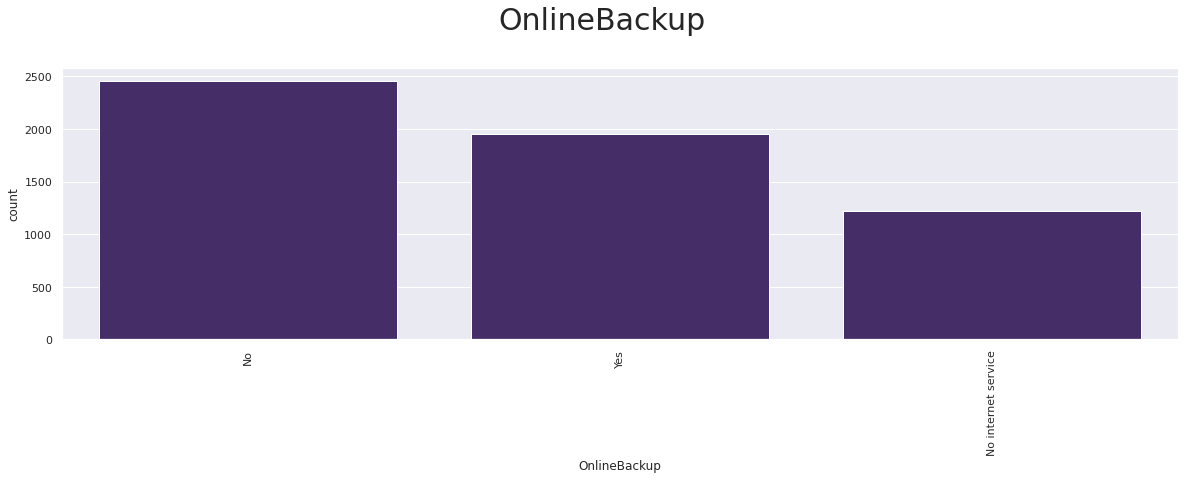

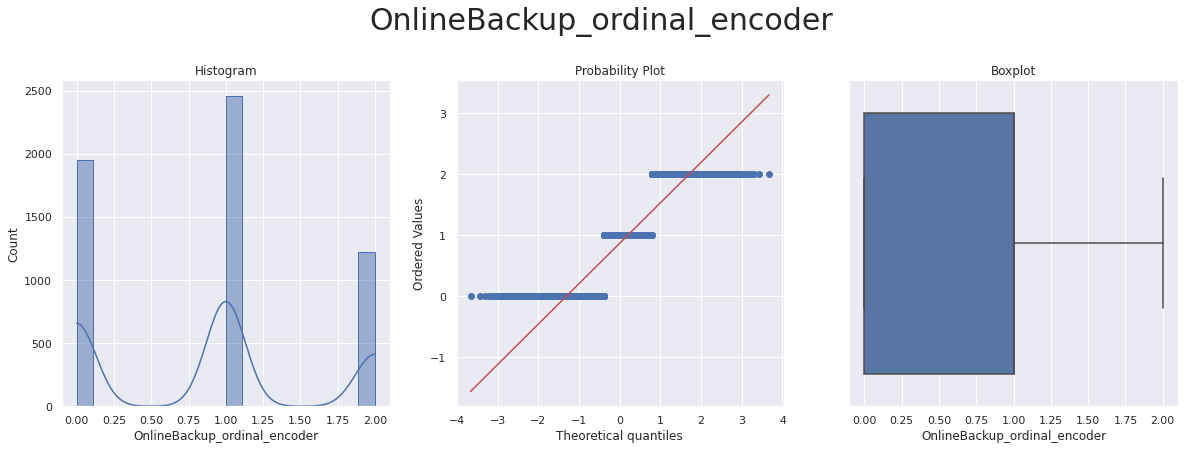



* Variable Analyzed: DeviceProtection
* Applied transformation: ['DeviceProtection_ordinal_encoder'] 



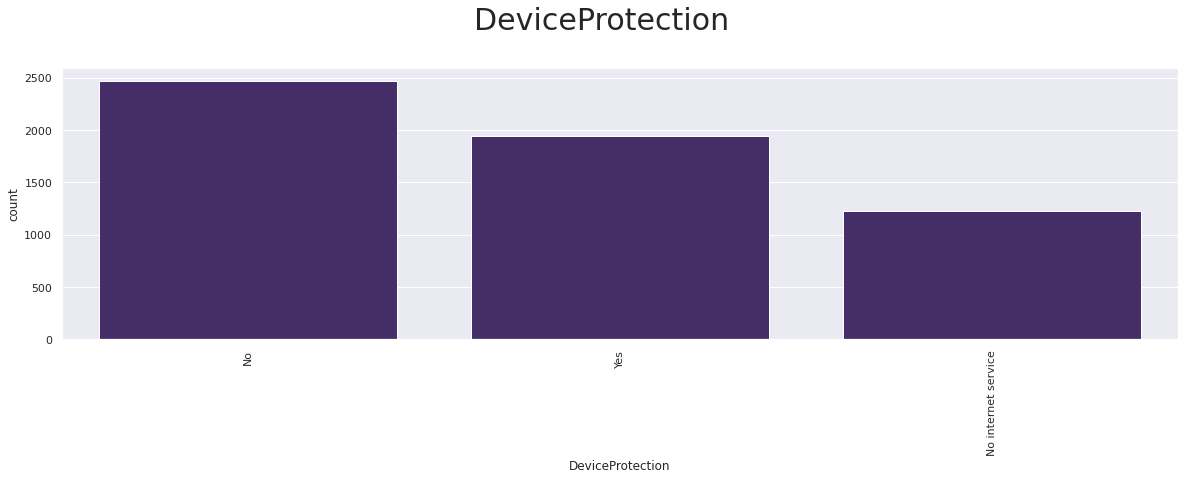

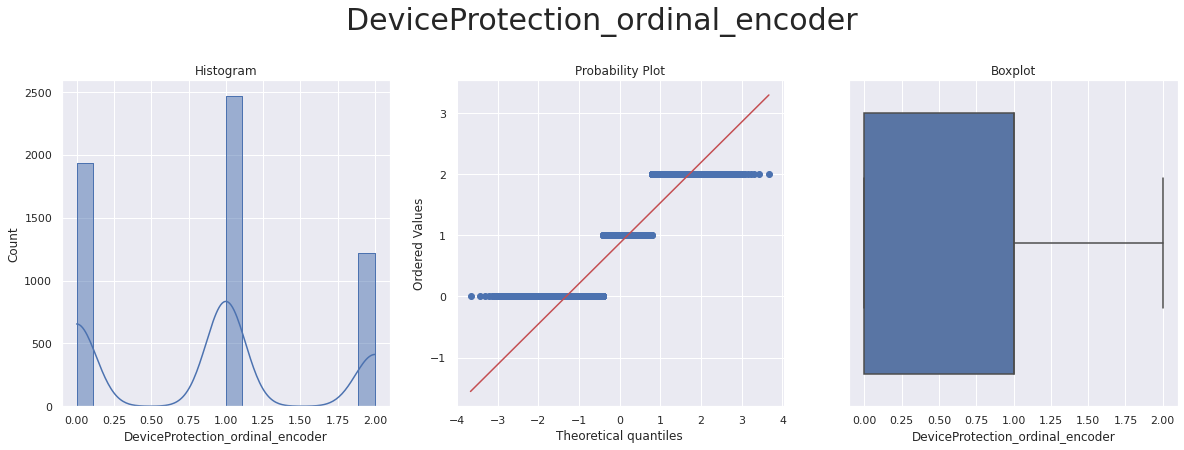



* Variable Analyzed: TechSupport
* Applied transformation: ['TechSupport_ordinal_encoder'] 



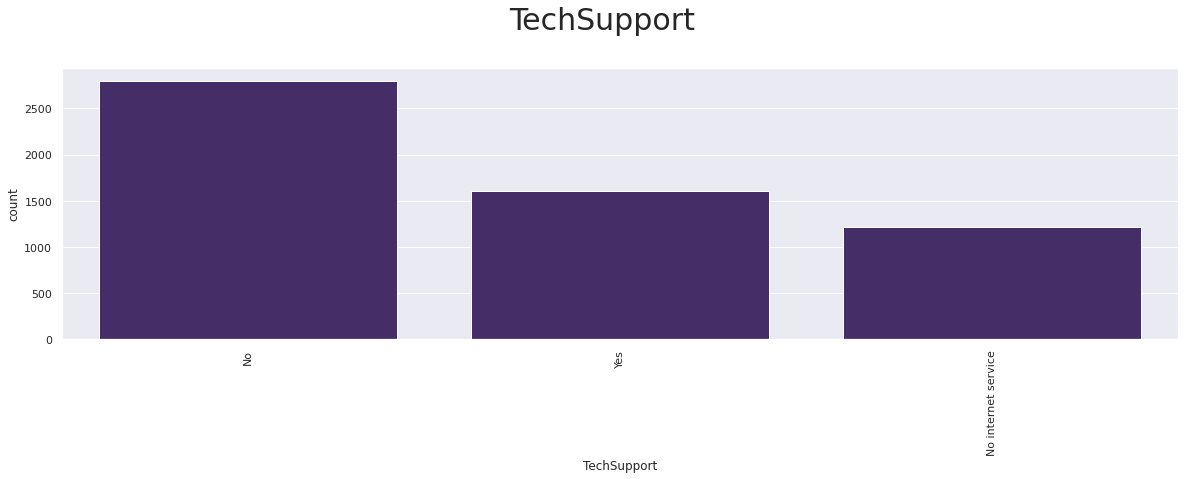

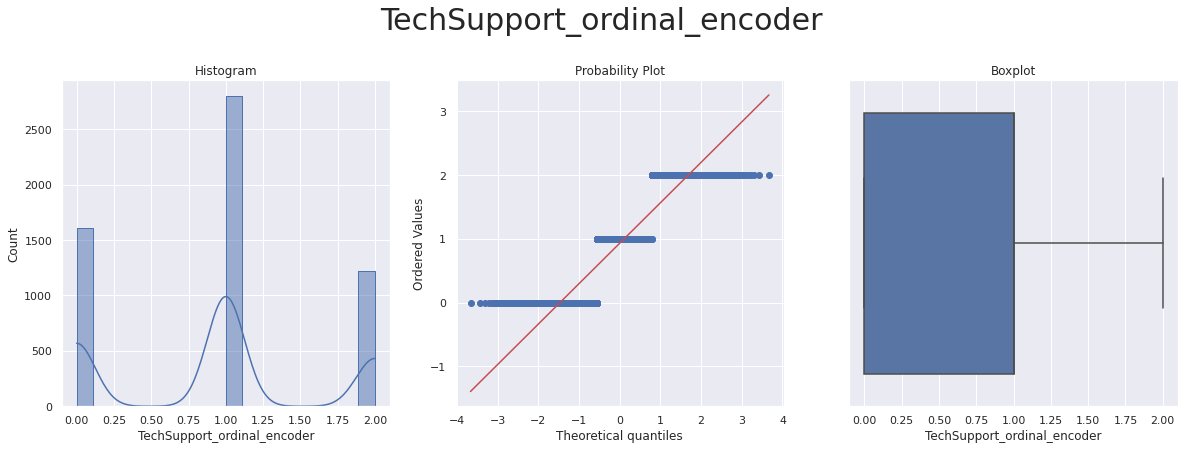



* Variable Analyzed: StreamingTV
* Applied transformation: ['StreamingTV_ordinal_encoder'] 



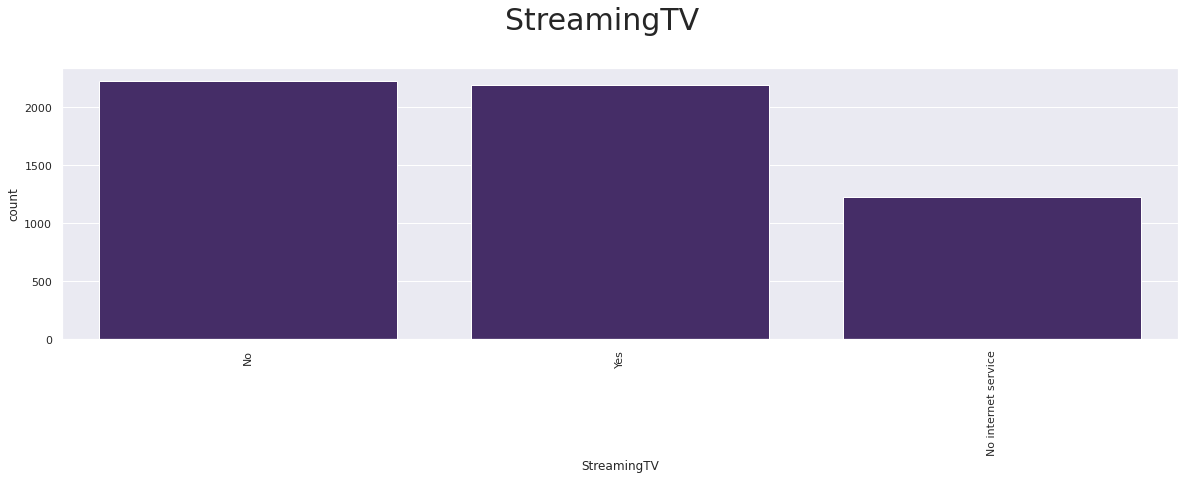

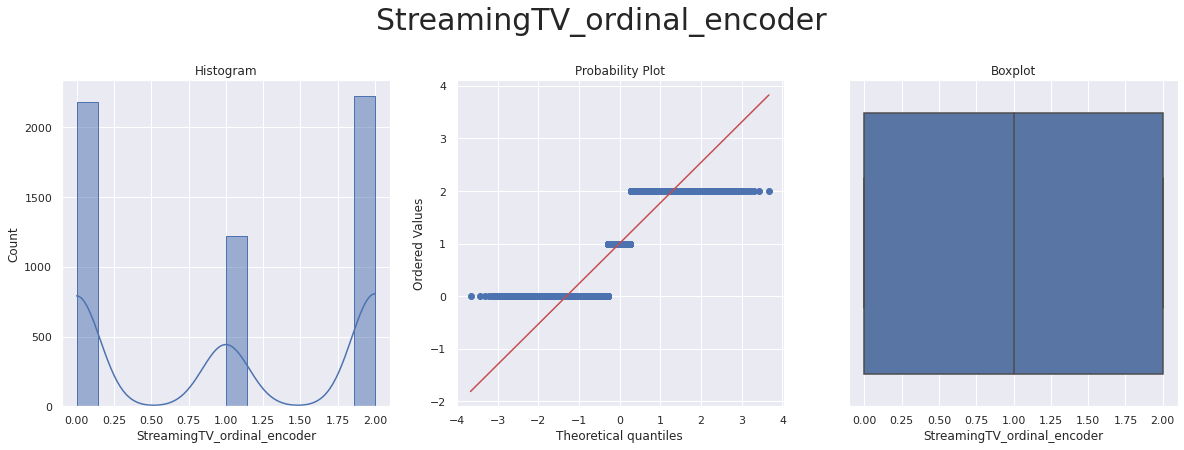



* Variable Analyzed: StreamingMovies
* Applied transformation: ['StreamingMovies_ordinal_encoder'] 



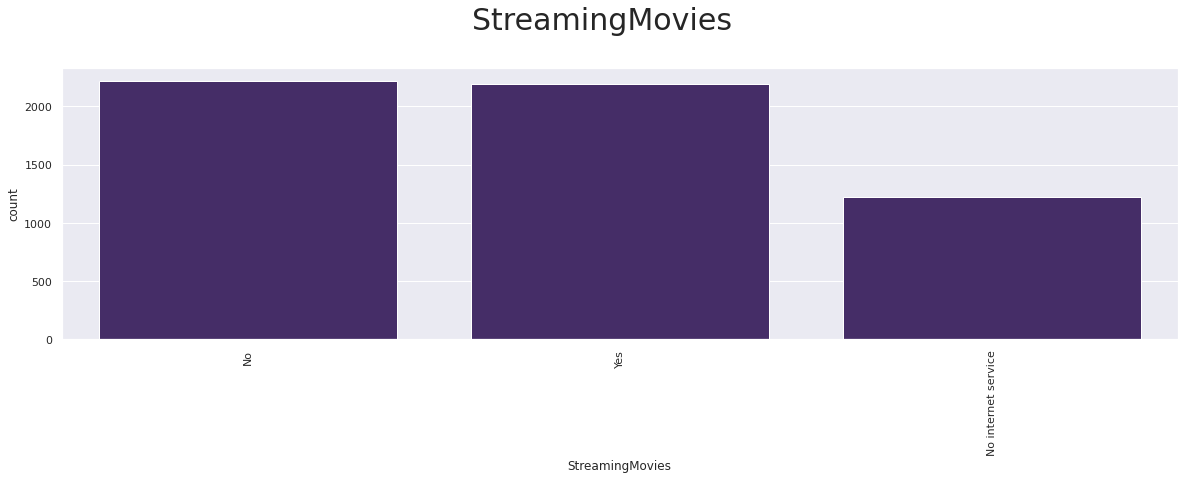

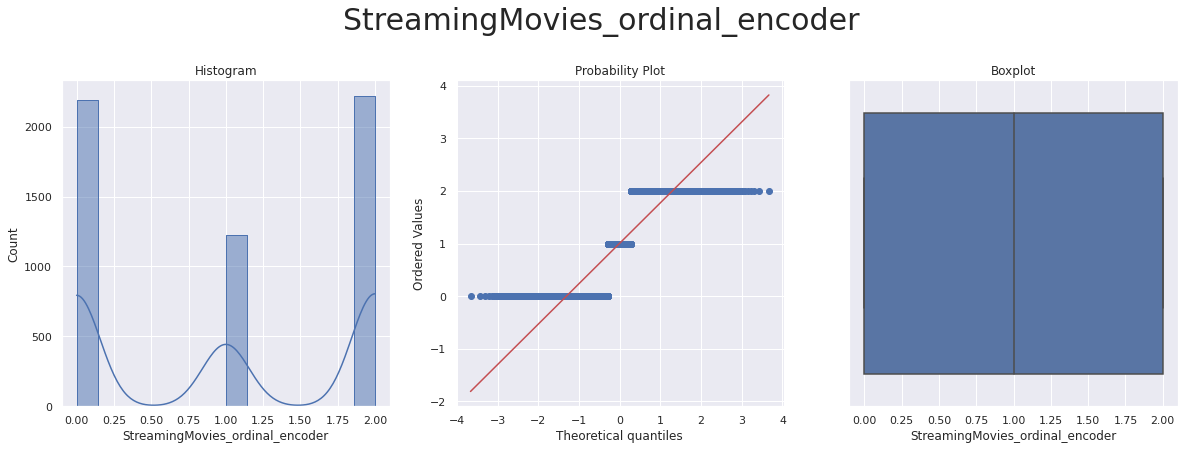



* Variable Analyzed: Contract
* Applied transformation: ['Contract_ordinal_encoder'] 



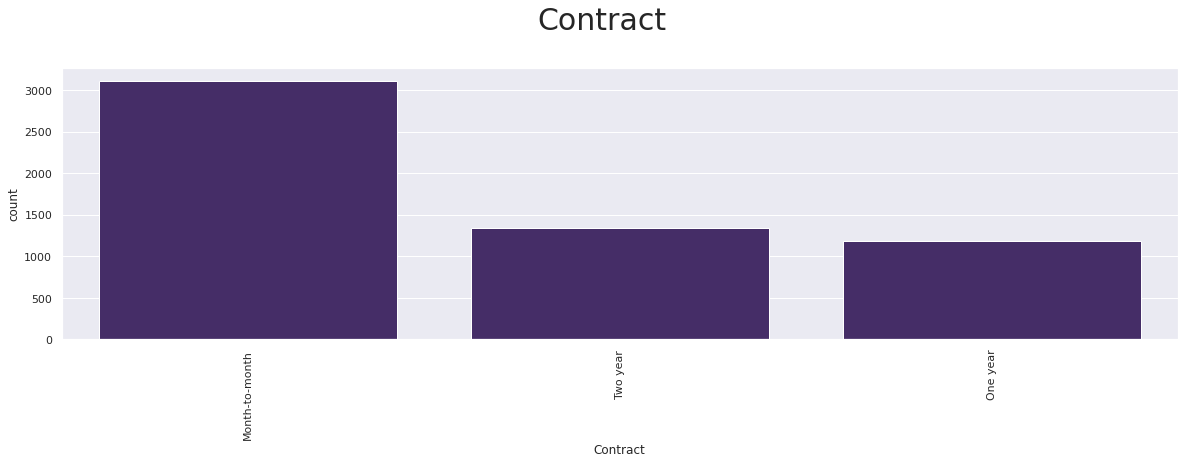

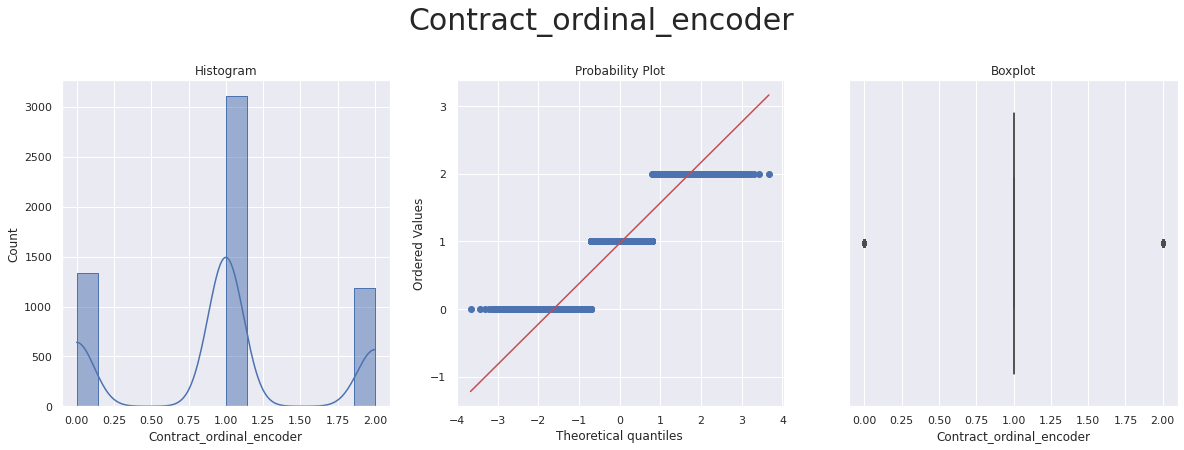



* Variable Analyzed: PaperlessBilling
* Applied transformation: ['PaperlessBilling_ordinal_encoder'] 



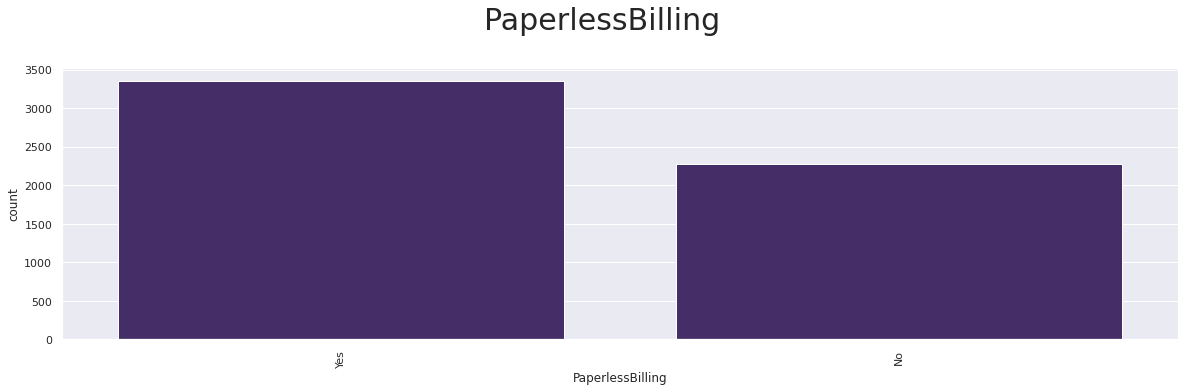

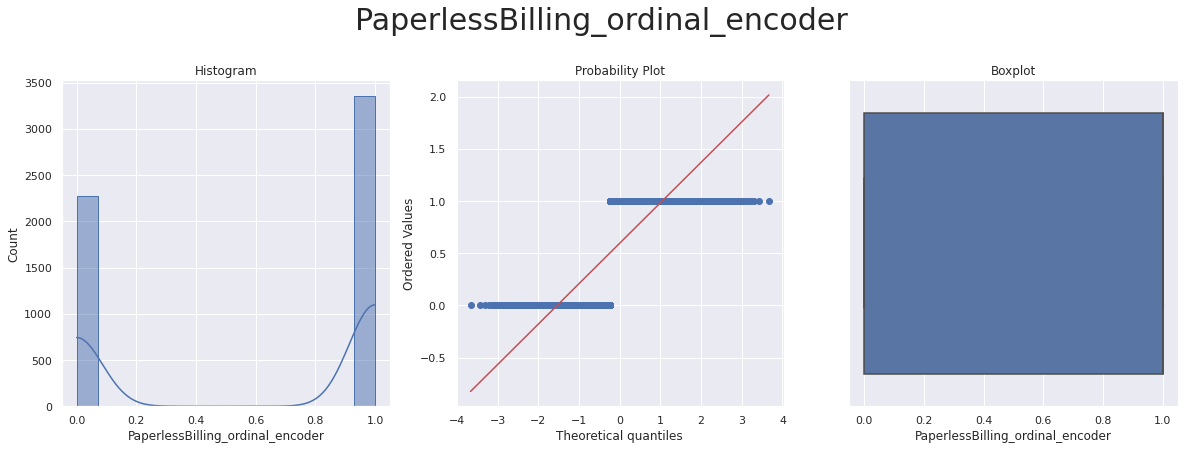



* Variable Analyzed: PaymentMethod
* Applied transformation: ['PaymentMethod_ordinal_encoder'] 



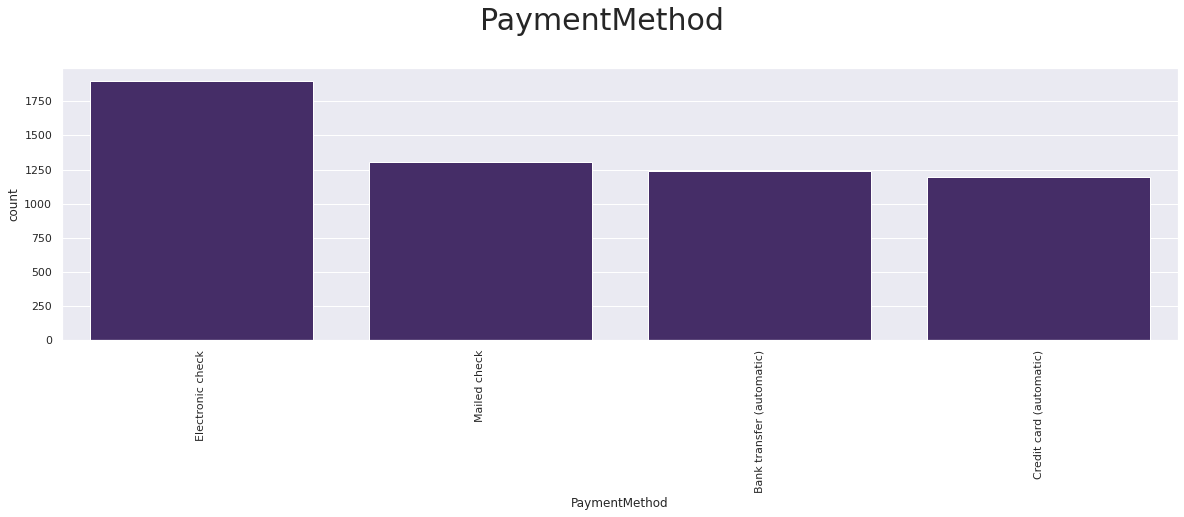

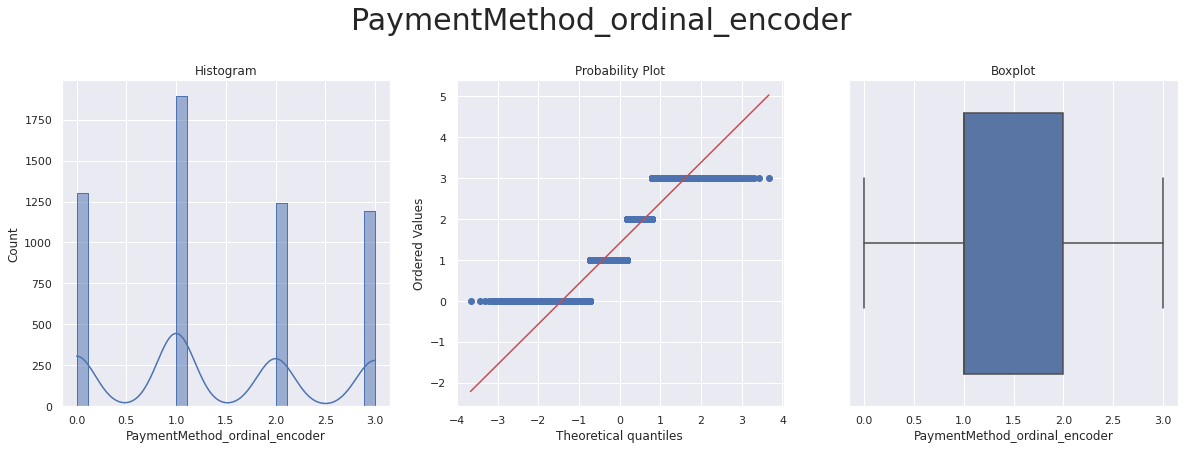

In [16]:
df_engineering = FeatureEngineering(df=df_engineering,analysis_type='ordinal_encoder')

* For each variable, write you conclusion on how the transformation(s) look(s) to be effective
  * Location': ordinal encoder - boxplot looks good, qq plot could be better - evaluate additional need for numerical transformation
  * 'WindGustDir: ordinal encoder - boxplot looks good, qq plot could be better - evaluate additional need for numerical transformation
  * 'WindDir9am': ordinal encoder - boxplot looks bit skewed, qq plot could be better - evaluate additional need for numerical transformation
  * 'WindDir3pm': ordinal encoder - boxplot looks good, qq plot could be better - evaluate additional need for numerical transformation
  * 'State': ordinal encoder - transformed to numerical - evaluate additional need for numerical transformation



* Step 5: If you are satisfied, apply the selected transformation to the Train and Test set

In [17]:
# the steps are: 
# 1 - select given transformation and respective variable(s)
# 2 - create transformer
# 3 - fit_transform into TrainSet
# 4 - transform into TestSet

variable_categ_enc = variables_engineering
if variable_categ_enc: 
  encoder = OrdinalEncoder(encoding_method='arbitrary', variables = variable_categ_enc)
  TrainSet = encoder.fit_transform(TrainSet)
  TestSet = encoder.transform(TestSet)


print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


### Handle Outliers (Winsorizer:caps maximum and/or minimum values)

* Step 1: Select variable(s)

* **Quick reminder: The variable(s) has(ve) to numerical**

In [ ]:
variables_engineering = ['tenure','MonthlyCharges','TotalCharges']
variables_engineering

* Step 2: Select the engineering transformation(s)

In [ ]:
from feature_engine.outliers import Winsorizer

* Step 3: Create a separate dataframe, with your variable(s)

In [ ]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

* Step 4: Create engineered variables(s) applying the transformation(s), assess engineered variables distribution and select most suitable method

In [ ]:
df_engineering = FeatureEngineering(df=df_engineering,analysis_type='outlier_winsorizer')

* For each variable, write you conclusion on how the transformation(s) look(s) to be effective
  * For all variables - it didn't improved the boxplot distribution or qq plot


* Step 5: If you are satisfied, apply the selected transformation to the Train and Test set


In [ ]:
# the steps are: 
# 1 - select given transformation and respective variable(s)
# 2 - create transformer
# 3 - fit_transform into TrainSet
# 4 - transform into TestSet


### Winsorizer Gaussian
variable_out_gaussian = []
if variable_out_gaussian:
  out_transf =Winsorizer(capping_method='gaussian',tail='both', fold=3,variables = variable_out_gaussian)
  TrainSet = out_transf.fit_transform(TrainSet)
  TestSet = out_transf.transform(TestSet)

### Winsorizer IQR
variable_out_iqr = []
if variable_out_iqr:
  out_transf =Winsorizer(capping_method='iqr',tail='both', fold=3,variables = variable_out_iqr)
  TrainSet = out_transf.fit_transform(TrainSet)
  TestSet = out_transf.transform(TestSet)

print("* Winsorizer Outlier transformation done!")

### SmartCorrelatedSelection Variables

* Step 1: Select variable(s)

In [ ]:
# from raw numerical variables
# variables_engineering = ['MonthlyCharges', 'TotalCharges', 'tenure']
# variables_engineering

* Step 2: Select the engineering transformation(s)

In [ ]:
from feature_engine.selection import SmartCorrelatedSelection

* Step 3: Create a separate dataframe, with your variable(s)

In [ ]:
df_engineering = TrainSet.copy()
df_engineering.head(3)

* Step 4: Create engineered variables(s) applying the transformation(s), assess engineered variables distribution and select most suitable method for each variable

In [ ]:
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6,selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

In [ ]:
corr_sel.features_to_drop_

* Step 5: If you are satisfied, apply the selected transformers to the Train and Test set

In [ ]:
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6,selection_method="variance")
TrainSet = corr_sel.fit_transform(TrainSet)
TestSet = corr_sel.transform(TestSet)

print(f"* correlated feature sets: \n{corr_sel.correlated_feature_sets_}\n")
print(f"* features to drop: \n{corr_sel.features_to_drop_}\n")
print("* SmartCorrelatedSelection transformation done!")

---

# So what is the conclusion? :)


The list below shows the transformations needed for feature engineering.
  * You will add these steps into the ML Pipeline


Feature Engineering Transformers
  * Ordinal categorical encoding: `['gender', 'Partner', Dependents', 'PhoneService','MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','Contract', 'PaperlessBilling', 'PaymentMethod']`
  * Smart Correlation Selection: `['OnlineSecurity', 'DeviceProtection', 'TechSupport']`
  